# Homework 1

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

* Do a grid convergence study to test the accuracy of your method.
* Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.


In [2]:
%precision 3
%matplotlib notebook

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

## RECAP: Chebyshev solution of Boundary Value Problems

If instead of an equally (or arbitrarily) spaced grid, we choose the Chebyshev nodes and compute derivatives in a stable way (e.g., via interpolating into the Chebyshev basis), we should have a very accurate method.  Let's return to our test equation

$$ -u''(x) = f(x) $$

subject to some combination of Neumann and Dirichlet boundary conditions.

<IPython.core.display.Javascript object>


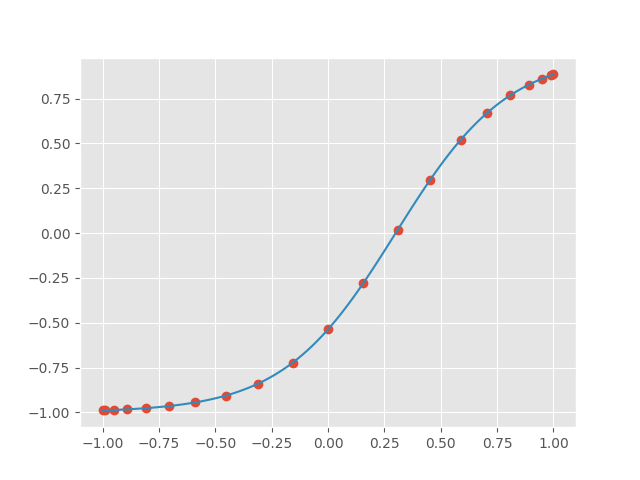

In [8]:
# The code in this cell was taken from the class notebook FDHighOrder

def vander_chebyshev(x, n=None):
    """
    Generates a Vandermond matrix using Chebyshev polynomials.
    """
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T


def chebeval(z, n=None):
    """
    Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z
    """
    z = numpy.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

def laplacian_cheb(n, rhsfunc, left, right):
    """
    Solve the Laplacian boundary value problem on (-1,1) using n elements with rhsfunc(x) forcing.
    The left and right boundary conditions are specified as a pair (deriv, func) where
      * deriv=0 for Dirichlet u(x_endpoint) = func(x_endpoint)
      * deriv=1 for Neumann u'(x_endpoint) = func(x_endpoint)
    """
    x = cosspace(-1, 1, n+1)  # n+1 points is n "elements"
    T = chebeval(x)
    L = -T[2]
    rhs = rhsfunc(x)
    for i,deriv,func in [(0, *left), (-1, *right)]:
        L[i] = T[deriv][i]
        rhs[i] = func(x[i])
    return x, L.dot(numpy.linalg.inv(T[0])), rhs

class exact_tanh:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, x):
        return numpy.tanh(self.k*(x - self.x0))
    def du(self, x):
        return self.k * numpy.cosh(self.k*(x - self.x0))**(-2)
    def ddu(self, x):
        return -2 * self.k**2 * numpy.tanh(self.k*(x - self.x0)) * numpy.cosh(self.k*(x - self.x0))**(-2)

#TODO: remove below
    
# Calculate and plot the Chebyshev solution to the BVP.
ex = exact_tanh(2, .3)
x, L, rhs = laplacian_cheb(20, lambda x: -ex.ddu(x), left=(0,ex.u), right=(1,ex.du))
pyplot.plot(x, numpy.linalg.solve(L, rhs), 'o')

# Plot the exact solution
xx = numpy.linspace(-1, 1, 100)
pyplot.plot(xx, ex.u(xx));